In [ ]:
def deck_to_vector(deck_id):   
    v = [0]*len(all_card_names)
    for i, name in enumerate(all_card_names):
        for card_name in all_decks[deck_id]['cards']:
            if card_name == name:
                v[i]+=1
    return v

deck_vectors = [deck_to_vector(deck_id) for deck_id in all_decks]

In [ ]:
def most_common_cards(deck, k):
    deck.sort(key = lambda deck: deck[0], reverse=True)
    return [card for card in deck[:k]]  

def decks_by_label(a_label):
    return [(deck, label) for (deck, label) in decks_labels if label == a_label]


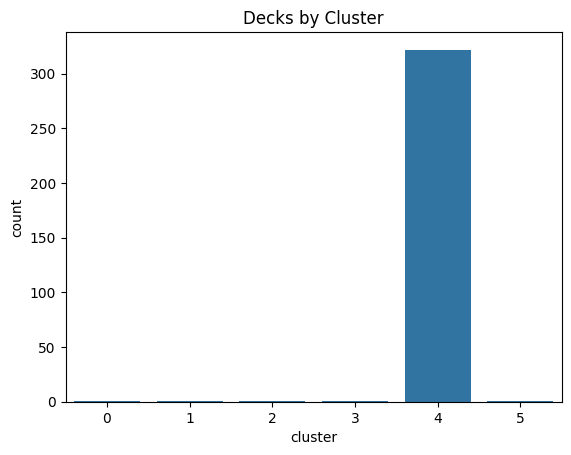

In [ ]:
import dask_ml.cluster
import seaborn as sns
import matplotlib.pyplot as plt

n_clusters = 6
oversampling_factor = 7 

km = dask_ml.cluster.KMeans(n_clusters=n_clusters, oversampling_factor=oversampling_factor)
km.fit(deck_vectors)

labels = list(km.labels_.compute()) #We call compute on it because it's lazy
decks_labels = [(all_decks[deck_id]['cards'], label) for deck_id,label in list(zip(all_decks,labels))]
#decks_labels = list(zip(all_decks,labels)) #Now we can pair each deck to its label.

label_counts = [(label,len(decks_by_label(label))) for label in range(n_clusters)]
counts = [count for _, count in label_counts]
points = {
    'cluster':[label for label, _ in label_counts],
    'count':[count for _, count in label_counts],
}

sns.barplot(x="cluster", y="count", data=points).set_title("Decks by Cluster")
plt.savefig('figure 1')

In [ ]:
clusters = km.predict(deck_vectors)
deck_vectors.append(clusters)

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
plotX = pd.DataFrame(np.array(deck_vectors))
pca_1d = PCA(n_components = 1)
pca_2d = PCA(n_components = 2)
pca_3d = PCA(n_components = 3)

In [ ]:
k = 40
for LABEL in range(8):
    label_set = set(most_common_cards(decks_by_label(LABEL)[0][0], k))
    for deck, label in decks_by_label(LABEL):
        label_set.intersection(set(most_common_cards(deck, k)))
    label_set = set(label_set)
    print("Cluster number {}:".format(LABEL))
    print(label_set)
    print("\n")

Cluster number 0:
{'Urborg, Tomb of Yawgmoth', 'Roaming Throne', 'Phyrexian Reclamation', 'Sol Ring', 'Sheoldred, the Apocalypse', 'Oathsworn Vampire', 'Smoldering Marsh', 'Welcoming Vampire', 'Swords to Plowshares', "Patriarch's Bidding", 'Phyrexian Arena', 'Rakish Heir', 'Swamp', 'Stensia Masquerade', 'Sorin of House Markov // Sorin, Ravenous Neonate', 'Shattered Sanctum', 'Patron of the Vein', 'Stromkirk Captain', 'Plateau', 'Vito, Thorn of the Dusk Rose', 'Scrubland', 'Nomad Outpost', 'Skullclamp', 'Sacred Foundry', 'Ruinous Ultimatum', 'Plains', "Teferi's Protection", "Urza's Incubator", 'Path to Exile', 'Olivia Voldaren', 'Sundown Pass', 'Sorin, Imperious Bloodlord', 'Vampiric Tutor', 'Sanctum Seeker', 'Savai Triome', 'Nighthawk Scavenger', "Olivia's Wrath", 'The Meathook Massacre', 'Village Rites', 'Orcish Bowmasters'}


Cluster number 1:
{'Gauntlet of Power', 'Highway Robbery', 'Thrill of Possibility', 'Spiteful Banditry', 'Gauntlet of Might', 'Seize the Spoils', 'Swiftfoot Boo

IndexError: list index out of range

In [ ]:
#returns the distribution of a card on the 8 clusters. 
# (e.g., a card appearing on decks of only one cluster will look like this [1,0,0,0,0,0,0,0]
# one appearing equally on decks from two different clusters
# like this [.5, 0, 0,.5, 0, 0, 0, 0] and so on).
def apparition_ratio(a_card):
    label_count = [0]*8
    for deck, label in decks_labels:
        if a_card in [card_name for _,card_name in deck]:
            label_count[label]+=1
    total_apps = sum(label_count)
    return ([count/total_apps for count in label_count],total_apps)
  
import math 

#just good all square root of dot product.
def distance(x,y):
    dist = 0.0
    for i, elem in enumerate(x):
        dist+= (elem-y[i])*(elem-y[i])
    return math.sqrt(dist)
#returns the k cards whose apparition vectors are closest
# (using Euclidian distance) to a given card.
def closest_cards(a_card, k):
    this_card = apparition_ratio(a_card)[0]
    distances = []
    for name in all_card_names:
        dist = distance(apparition_ratio(name)[0],this_card)
        distances.append((name, dist))
    distances.sort(key = lambda x: x[1])
    distances = [(name, dist) for name, dist in distances if name!=a_card]
    return [name for name,_ in distances[:k] ]